# RNN and CURBD analysis - trial averaged data
### Mouse: M044
### Session: 2024_12_04_09_30

#### Imports

In [151]:
# imports
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import sys
import os

# Add the project root to sys.path
import sys
sys.path.append('/data/PyalData')

import pyaldata as pyal
import pylab
from collections import Counter
import importlib

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# for RNN and CURBD
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from tools.curbd import curbd
from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd import rnn as rnnz
from tools.rnn_and_curbd import plotting as pltz
from tools.rnn_and_curbd import model_analysis as analyz
from tools.rnn_and_curbd import curbd as curbdz

importlib.reload(rnnz)
importlib.reload(pltz)
importlib.reload(analyz)
importlib.reload(curbdz)

np.random.seed(44)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load session data

In [2]:
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
mat_file = "M044_2024_12_04_09_30_pyaldata.mat"

In [3]:
fname = os.path.join(data_dir, mat_file)
df = pyal.mat2dataframe(fname, shift_idx_fields=True)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


In [4]:
df.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,idx_Sol_direction,values_Sol_duration,idx_Sol_duration,idx_sol_on,idx_earthquake_duration,idx_session_timer,all_chan_best,all_unit_guide,all_KSLabel,all_spikes
0,M044,M044_2024_12_04_09_30,0,free,60001,0.01,-1,59999,[],1.0,...,[],[],[],[],[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [0, 2], [0, 3], [1, 1], [1, 2], [1, 3...","[good, mua, good, mua, good, good, good, good,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,M044,M044_2024_12_04_09_30,1,intertrial,101,0.01,59999,60099,[],[],...,99,50,99,[],[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [0, 2], [0, 3], [1, 1], [1, 2], [1, 3...","[good, mua, good, mua, good, good, good, good,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,M044,M044_2024_12_04_09_30,2,trial,401,0.01,60099,60499,[],[],...,-1,50,-1,199,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [0, 2], [0, 3], [1, 1], [1, 2], [1, 3...","[good, mua, good, mua, good, good, good, good,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,M044,M044_2024_12_04_09_30,3,intertrial,101,0.01,60499,60599,[],[],...,99,100,99,[],[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [0, 2], [0, 3], [1, 1], [1, 2], [1, 3...","[good, mua, good, mua, good, good, good, good,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,M044,M044_2024_12_04_09_30,4,trial,401,0.01,60599,60999,[],[],...,-1,100,-1,199,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [0, 2], [0, 3], [1, 1], [1, 2], [1, 3...","[good, mua, good, mua, good, good, good, good,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Preprocessing

In [78]:
df_ = preprocess(df, only_trials=False)


/data/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 20000)


In [83]:
df_ = df_[df_["trial_name"] == "intertrial"]
df_.reset_index(drop=False, inplace=True)  # reset index

# bin size
BIN_SIZE = df_['bin_size'][0]

# correcting the trial length
df_['trial_length'] = (df_['trial_length'] / (BIN_SIZE * 100)).astype(int)
areas = ["M1_rates", "Dls_rates"]
df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

In [84]:
df_.head()

,level_0,index,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,...,idx_session_timer,all_chan_best,all_unit_guide,all_KSLabel,all_spikes,all_rates,sol_level_id,sol_contra_ipsi,M1_rates,Dls_rates
0,0,1,M044,M044_2024_12_04_09_30,1,intertrial,33,0.03,19999,20033,...,[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[9.000157316525778, 0.0, 0.0, 0.0, 12.9494756...",NaN,NaN,"[[0.0, 0.04343213513493538, 0.0, 0.0, 0.0, 20....","[[9.000157316525778, 0.0, 0.0, 0.0, 12.9494756..."
1,1,3,M044,M044_2024_12_04_09_30,3,intertrial,33,0.03,20166,20199,...,[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10.218119621276855, 0.0, 0.0, 0.000319675170...",NaN,NaN,"[[0.03477109130471945, 0.0, 0.0, 0.0, 0.0, 24....","[[10.218119621276855, 0.0, 0.0, 0.000319675170..."
2,2,5,M044,M044_2024_12_04_09_30,5,intertrial,33,0.03,20333,20366,...,[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00607092030501614, 0.0, 0.9141243373354276...",NaN,NaN,"[[0.03477109130471945, 33.16013813018799, 7.11...","[[0.00607092030501614, 0.0, 0.9141243373354276..."
3,3,7,M044,M044_2024_12_04_09_30,7,intertrial,233,0.03,20499,20733,...,[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[6.242093443870544, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,"[[0.0, 0.0, 16.631895303726196, 8.770401279131...","[[6.242093443870544, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,9,M044,M044_2024_12_04_09_30,9,intertrial,167,0.03,20866,21033,...,[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.914576401313146, 0.0, 0.0, 0.0, ...",NaN,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 16.631895303726196,...","[[0.0, 0.0, 0.914576401313146, 0.0, 0.0, 0.0, ..."


### Some parameters

In [127]:
# Get mouse number
mouse = mat_file.split('_')[0]

# perturbation time
perturbation_time = df_.idx_sol_on[0]
perturbation_time_sec = df_.idx_sol_on[0] * df['bin_size'][0]

# bin size
BIN_SIZE = df_['bin_size'][0]

# solenoid angles
trial_types: list = df_.trial_length.unique()
trial_types.sort()
trial_labels = [f"intertrial length {length}" for length in trial_types]
print(trial_labels)

# number of trials
num_trials = len(df_)
print(f"Number of trials: {num_trials}")

# Set interpolation factor for RNN 
dtFactor = 2

['intertrial length 33', 'intertrial length 100', 'intertrial length 167', 'intertrial length 233']
Number of trials: 534


### Conactanate trials only

In [ ]:
# getting trial avg data
trial_avg_rates = rnnz.average_by_trial(df_, trial_types, trial_col_name = 'trial_length')
shapes = [arr.shape[0] for arr in trial_avg_rates]
# print(shapes)

# concatenate data
concat_rates = np.concatenate(trial_avg_rates, axis=0)

# set up for RNN
trial_avg_activity = np.transpose(concat_rates)
reset_points = rnnz.get_intertrial_reset_points(df_, trial_avg_activity, trial_types, areas, dtFactor)
regions_arr = rnnz.get_regions(df_, areas)

print(f"Building {len(regions_arr)} region RNN network")
print(f"Regions: {[region[0] for region in regions_arr]}\n")

Trial length: 33
[0, 33, 133, 300, 533]
Building 2 region RNN network
Regions: ['M1', 'Dls']



### Plot RNN input

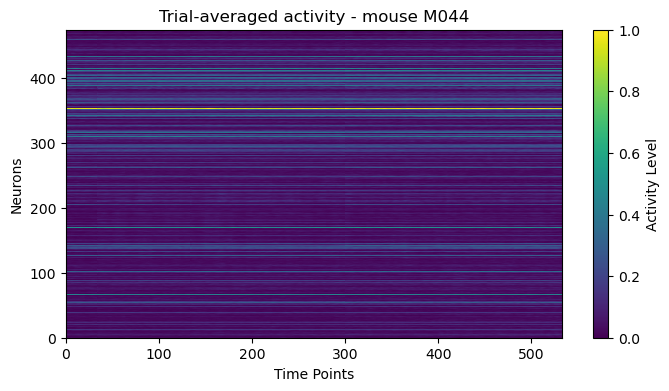

In [87]:
pltz.plot_neuron_activity(rnnz.rescale_array(trial_avg_activity.T), "Trial-averaged activity", mouse)

## RNN training

In [88]:
# RNN hyperparameters
nRunTrain = 5

reset points length: 5
last reset at: 1066
RNN input shape: (474, 533)
trial=0 pVar=0.946307 chi2=0.267472
trial=1 pVar=0.984324 chi2=0.078357
trial=2 pVar=0.987345 chi2=0.063362
trial=3 pVar=0.988616 chi2=0.057075
trial=4 pVar=0.989558 chi2=0.052389
trial=5 pVar=0.988985 chi2=0.055393


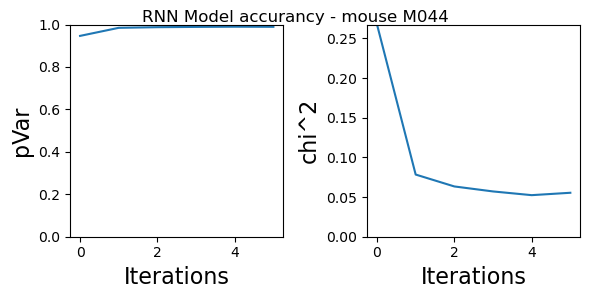

In [89]:
rnn_model, rnn_accuracy_fig = rnnz.run_rnn(trial_avg_activity, reset_points, regions_arr, df_, mouse, dtFactor = dtFactor, nRunTrain = nRunTrain)

### Plot RNN output

In [90]:
rnn_model_ = rnn_model.copy()
rnn_model_['RNN'] = rnnz.combine_rnn_time_bins(rnn_model)

RNN model output transformed from shape: (474, 1065) to (474, 533). Matching the original data shape of (474, 533)


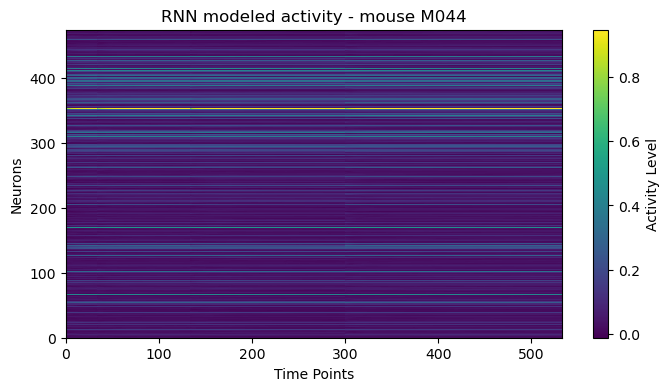

In [91]:
pltz.plot_neuron_activity(rnn_model_['RNN'].T, "RNN modeled activity", mouse)

## Analysis of model fit

### PCA whole model

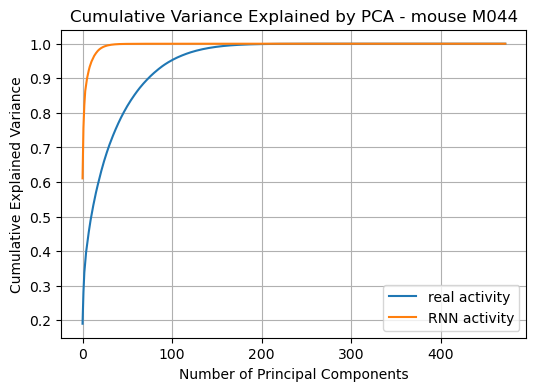

In [92]:
rnn_activity = rnn_model_['RNN'].T
real_activity = rnn_model_['Adata'].T
num_components = rnn_activity.shape[1] - 1

pca_real, pca_data_real = analyz.pca_fit_transform(real_activity, num_components)
pca_rnn, pca_data_rnn = analyz.pca_fit_transform(rnn_activity, num_components)

variance_figure = pltz.plot_pca_cum_var(pca_real, pca_rnn, mouse)

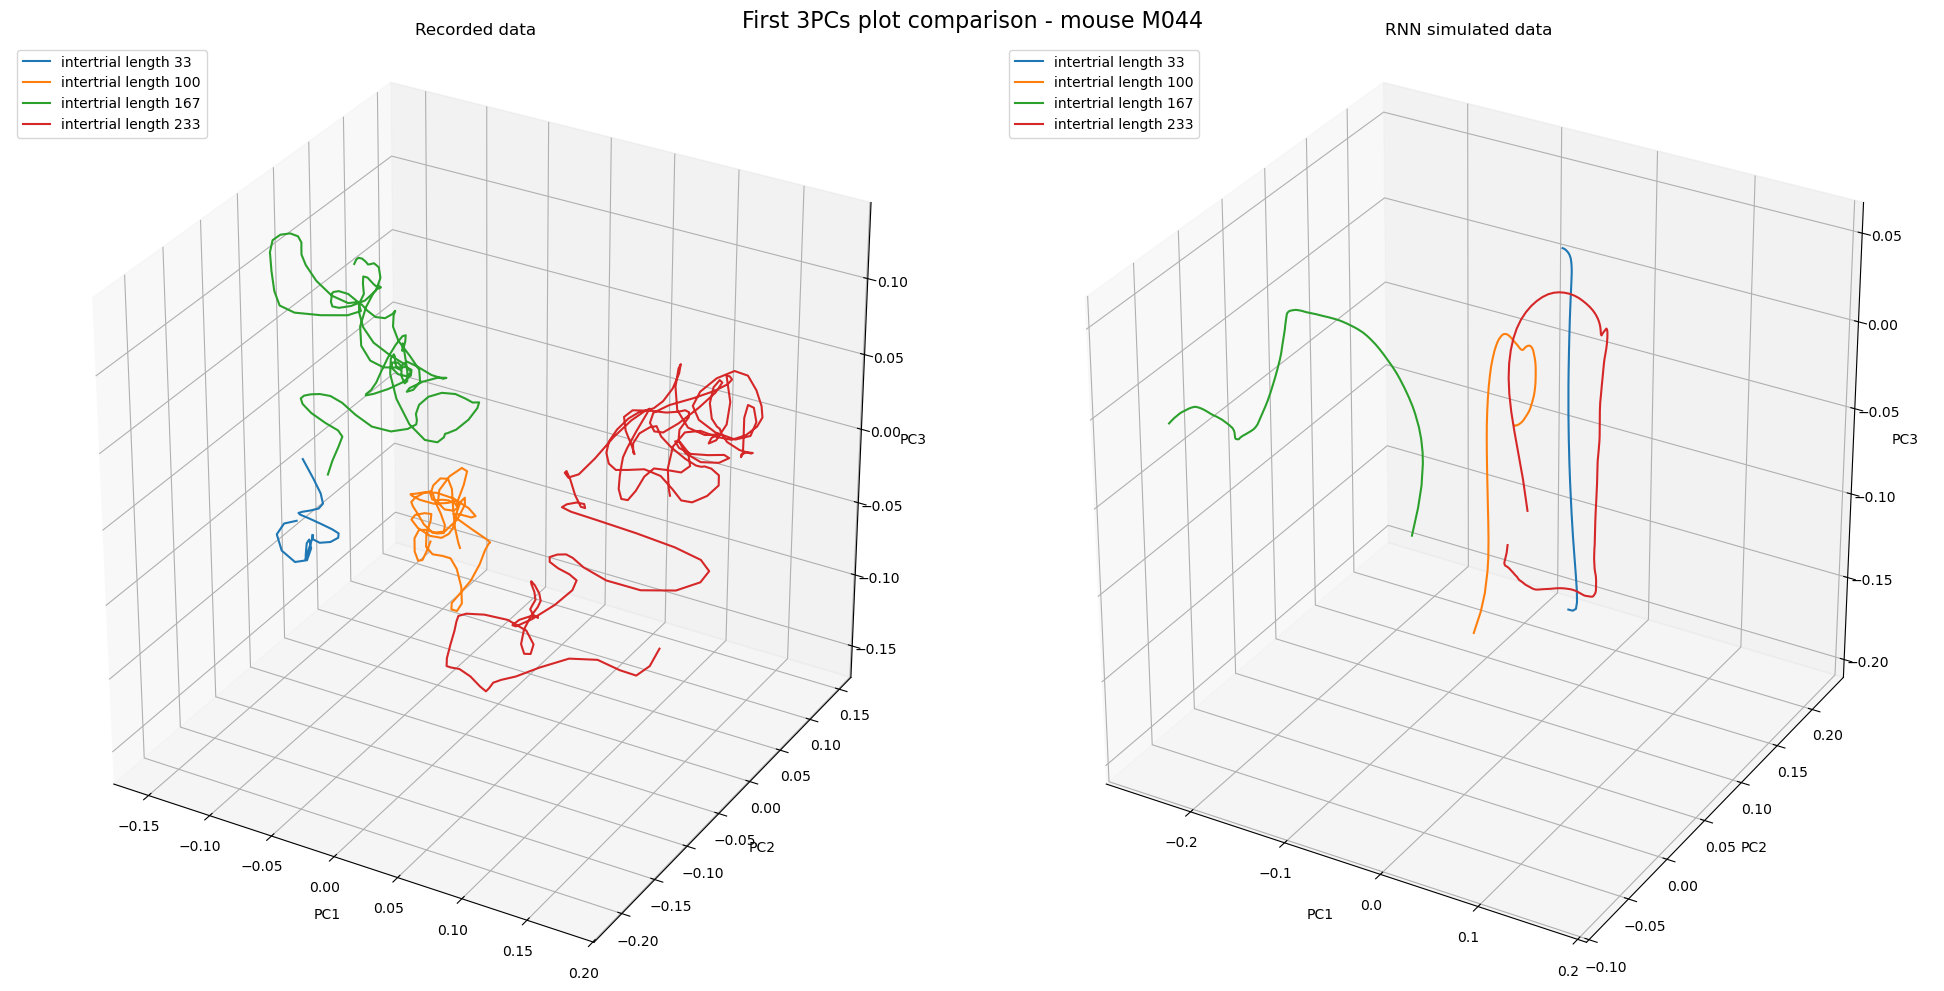

In [93]:
PCA_figure = pltz.plot_pca(pca_data_real, pca_data_rnn, shapes, mouse, trial_labels)

### CCA

In [94]:
model_cca = analyz.canoncorr(pca_data_real, pca_data_rnn)
ctrl1_cca = analyz.canoncorr(pca_data_real, pca_data_real)
ctrl2_cca = analyz.canoncorr(pca_data_rnn, pca_data_rnn)

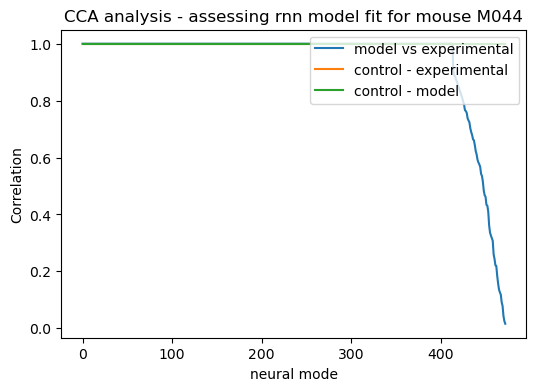

In [95]:
cca_figure = pltz.plot_cca(model_cca, ctrl1_cca, ctrl2_cca, mouse)

### PCA by brain region

In [96]:
PCA_data_real, pcas_real = analyz.pca_by_region(real_activity, regions_arr)
PCA_data_rnn, pcas_rnn = analyz.pca_by_region(rnn_activity, regions_arr)

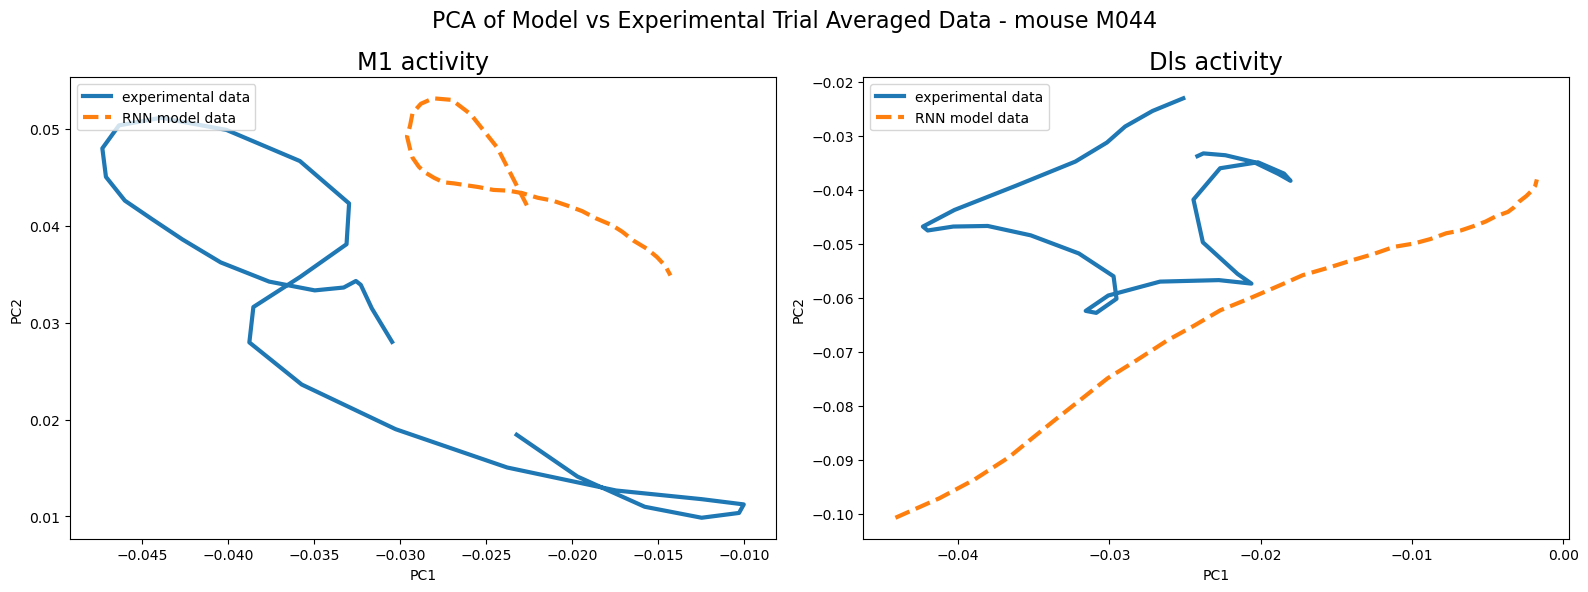

In [97]:
figure = pltz.plot_pca_by_region(PCA_data_real, PCA_data_rnn, shapes, regions_arr, mouse)

### Weight matrix

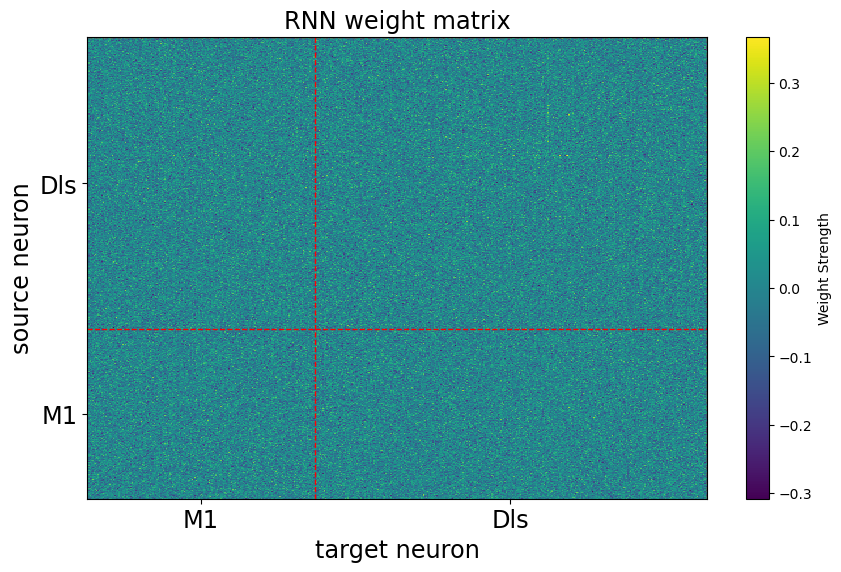

In [98]:
weight_matrix_fig = pltz.plot_rnn_weight_matrix(rnn_model, regions_arr)

### Firing rate analysis

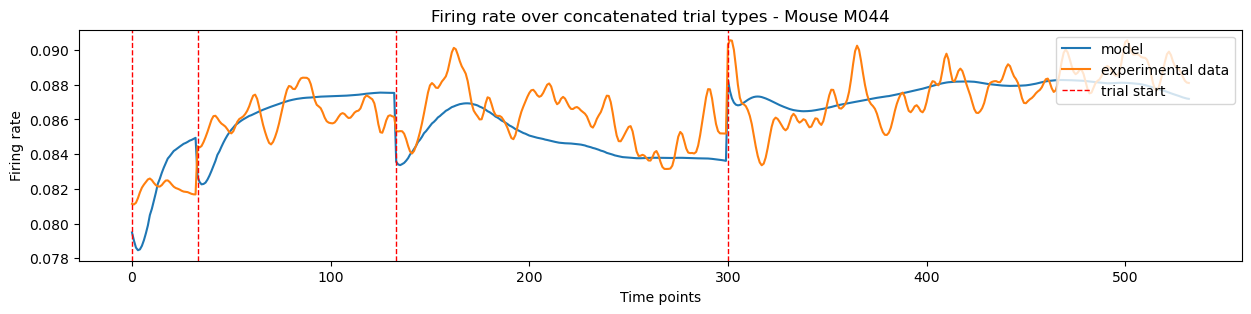

In [100]:
fr_fig = pltz.plot_firing_rates(rnn_model_, reset_points, mouse)

/home/zms24/Desktop/earthquake-analysis/tools/rnn_and_curbd/plotting.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


<Figure size 1500x600 with 0 Axes>

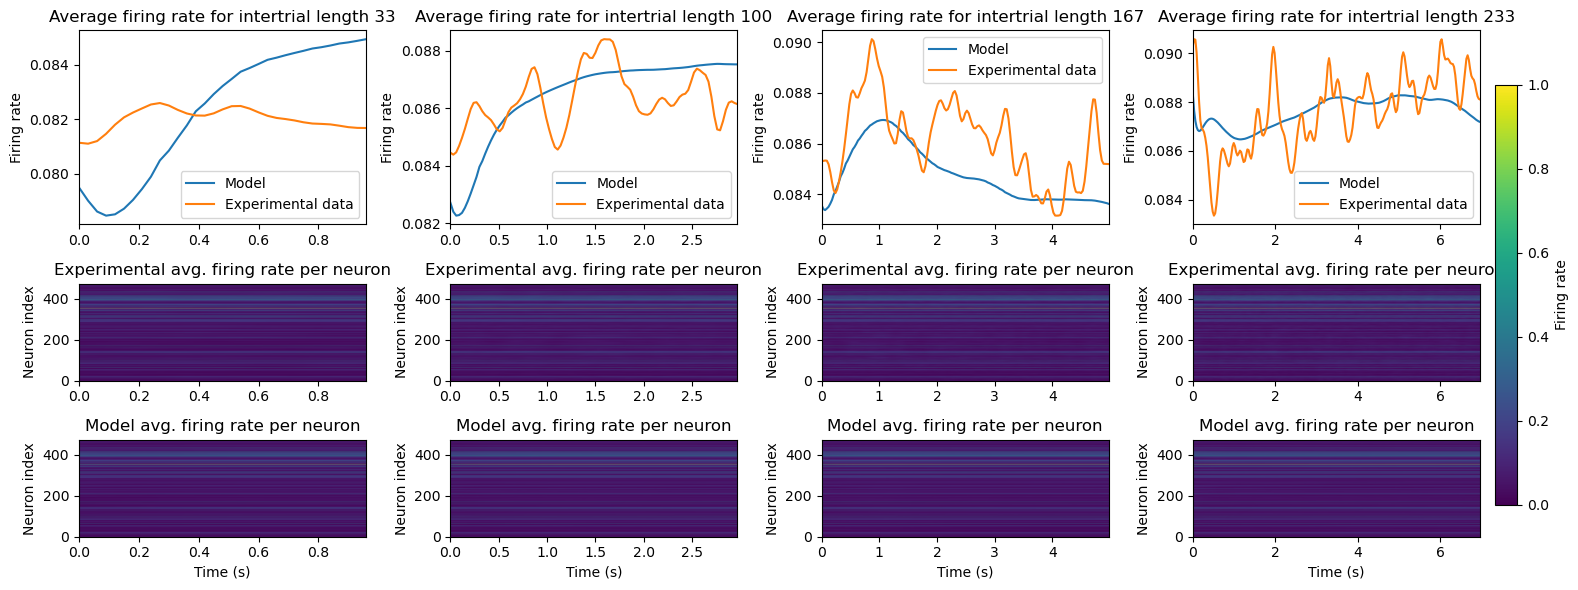

In [138]:
avg_fr_fig = pltz.plot_intertrial_avg_firing_rates(rnn_model_, shapes, trial_labels, bin_size=BIN_SIZE, mouse_num=mouse)

## CURBD

In [159]:
curbd_arr, curbd_labels = curbd.computeCURBD(rnn_model)
new_reset_points = rnnz.get_intertrial_reset_points(df_, trial_avg_activity, trial_types, areas, dtFactor=1)
n_regions = curbd_arr.shape[0]

Trial length: 33


In [162]:
currents, current_labels = curbdz.format_curbd_output(curbd_arr, curbd_labels, n_regions, new_reset_points)

In [165]:
print(shapes)

[33, 100, 167, 233]


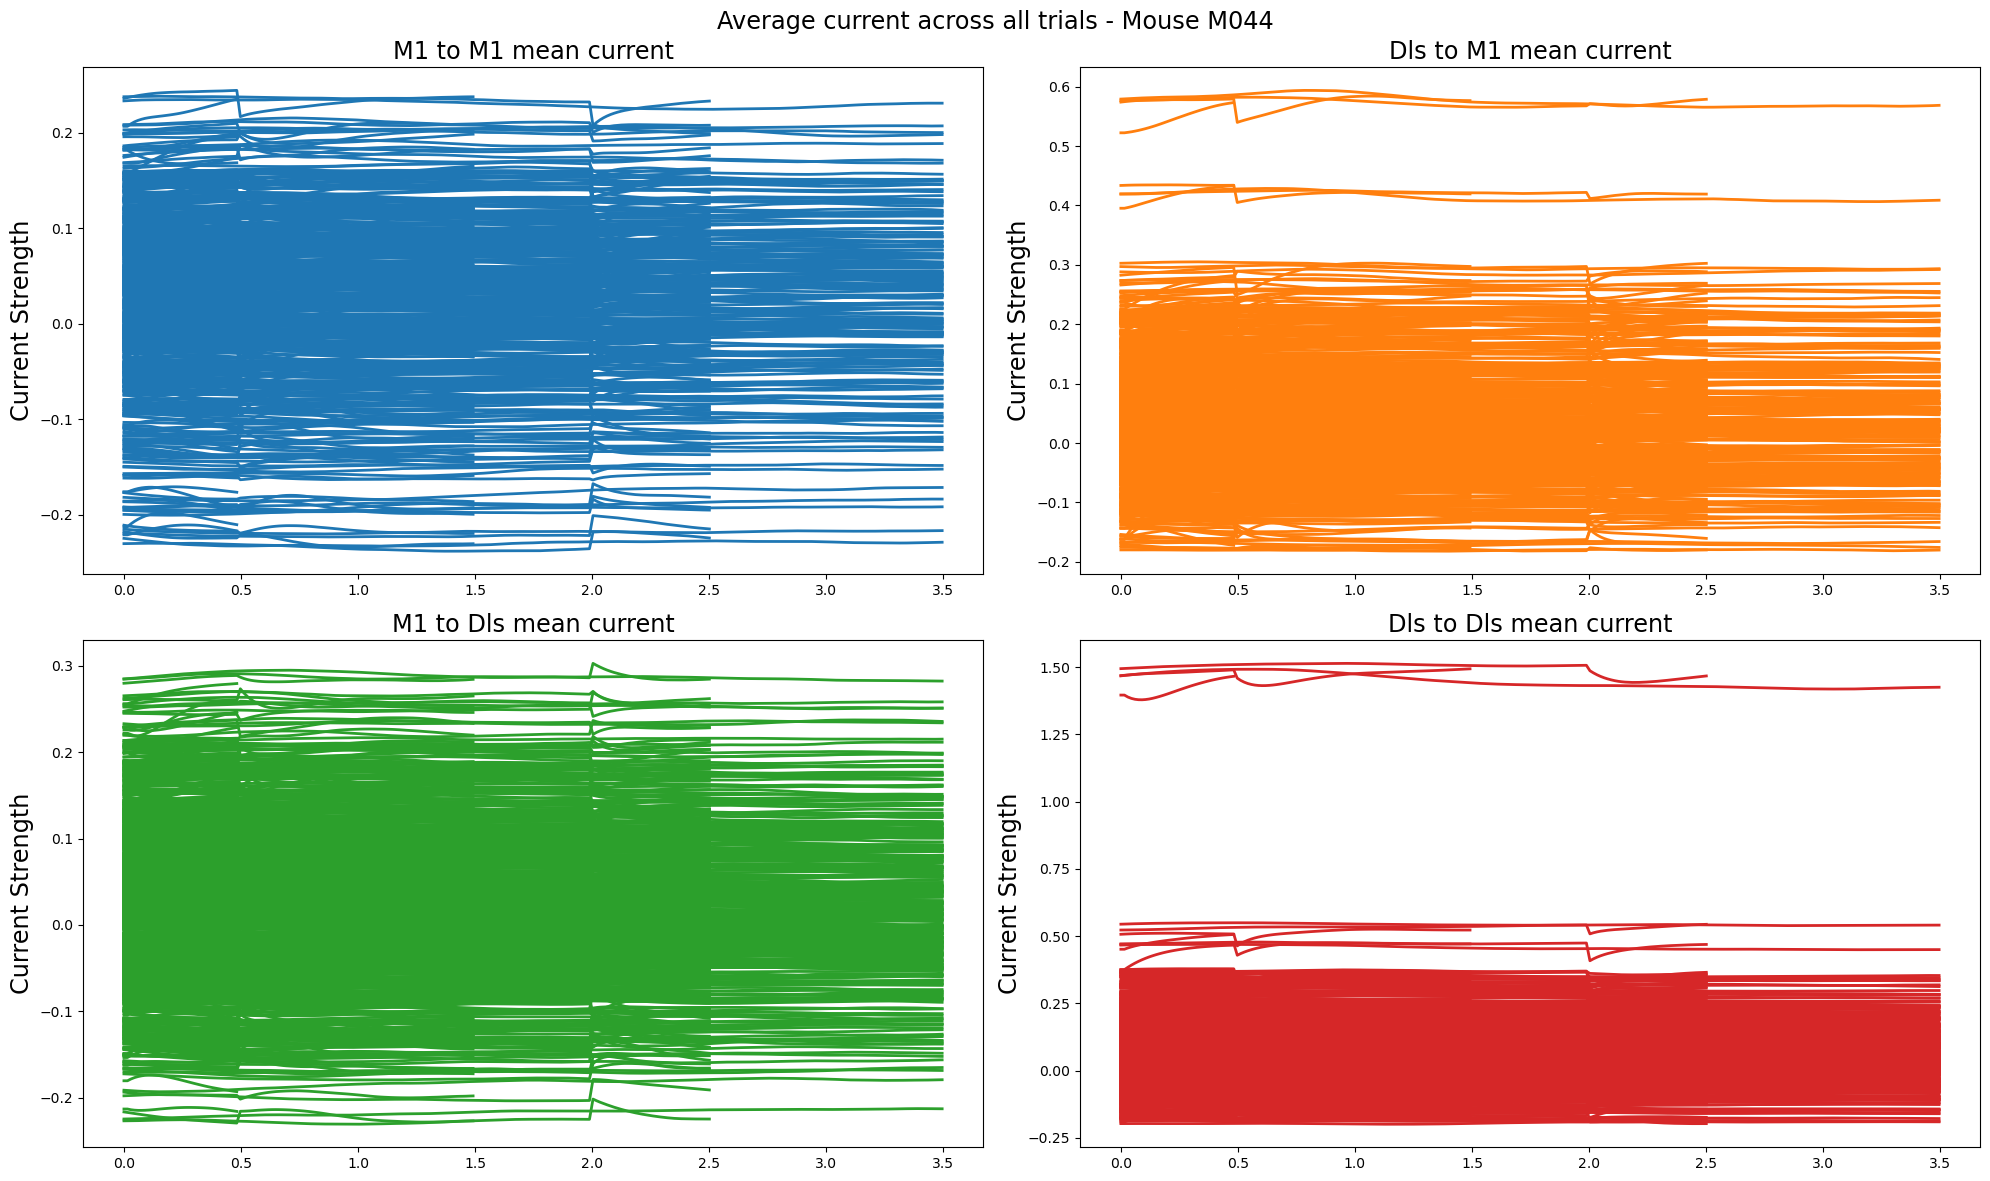

In [177]:
figure3 = pltz.plot_intertrial_currents(currents, current_labels, shapes, BIN_SIZE, dtFactor, mouse)

In [ ]:
currents_fig = pltz.plot_currents_by_region(currents, current_labels, perturbation_time=None, bin_size=BIN_SIZE, dtFactor=dtFactor, mouse_num=mouse)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

<Figure size 2000x1200 with 0 Axes>

In [150]:
pca_current_fig = pltz.plot_pca_currents(currents, current_labels, perturbation_time, mouse)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (174, 3) + inhomogeneous part.

<Figure size 1000x800 with 0 Axes>

### Saving RNN model

In [125]:
rnn_model_to_save = rnn_model.copy()
try:
    if isinstance(rnn_model_to_save['params'].get('nonLinearity'), np.ufunc):
        rnn_model_to_save['params']['nonLinearity'] = rnn_model_to_save['params']['nonLinearity'].__name__
    savemat(f"rnn_model_{mouse}.mat", {"rnn_model": rnn_model_to_save})
except Exception as e:
    print(f"Error saving RNN model for mouse {mouse}:", e)